<center><h1>Last_First_HW1</h1></center>
<br>
<center><font size="4">Vertebral Column Data</font></center>

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import arff

Get the Vertebral Column Data Set

In [2]:
file_data = arff.load(open('../data/vertebral_column_data/column_2C_weka.arff'))
features = [x[0] for x in file_data['attributes']]
df = pd.DataFrame(data = file_data['data'], columns = features) # Creating the dataframe
df['class'] = df['class'].map({'Normal':0,'Abnormal':1}) # altering values of class to 1 and 0 and adding a new column for it

### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

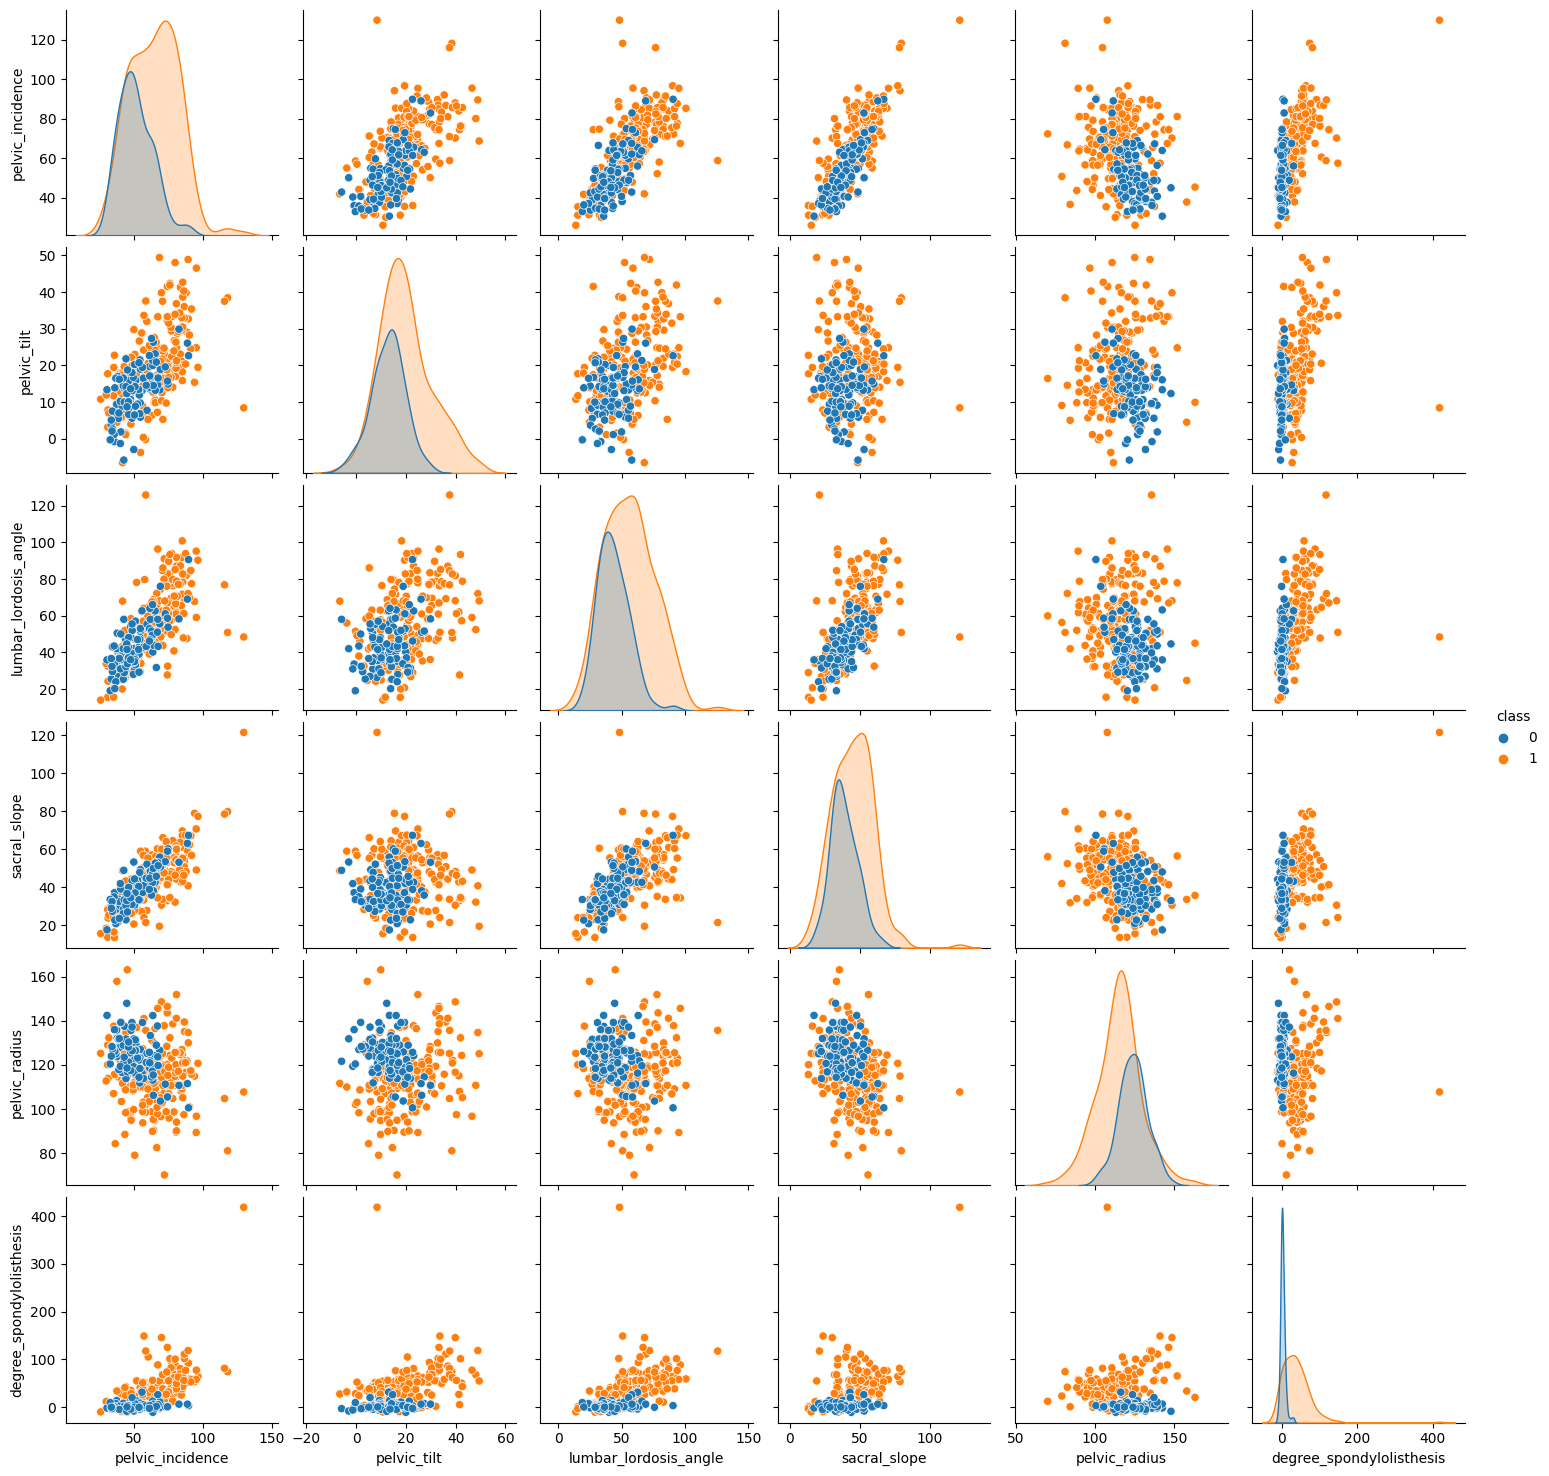

In [3]:
sns.pairplot(df, hue='class')

#### ii. Boxplots

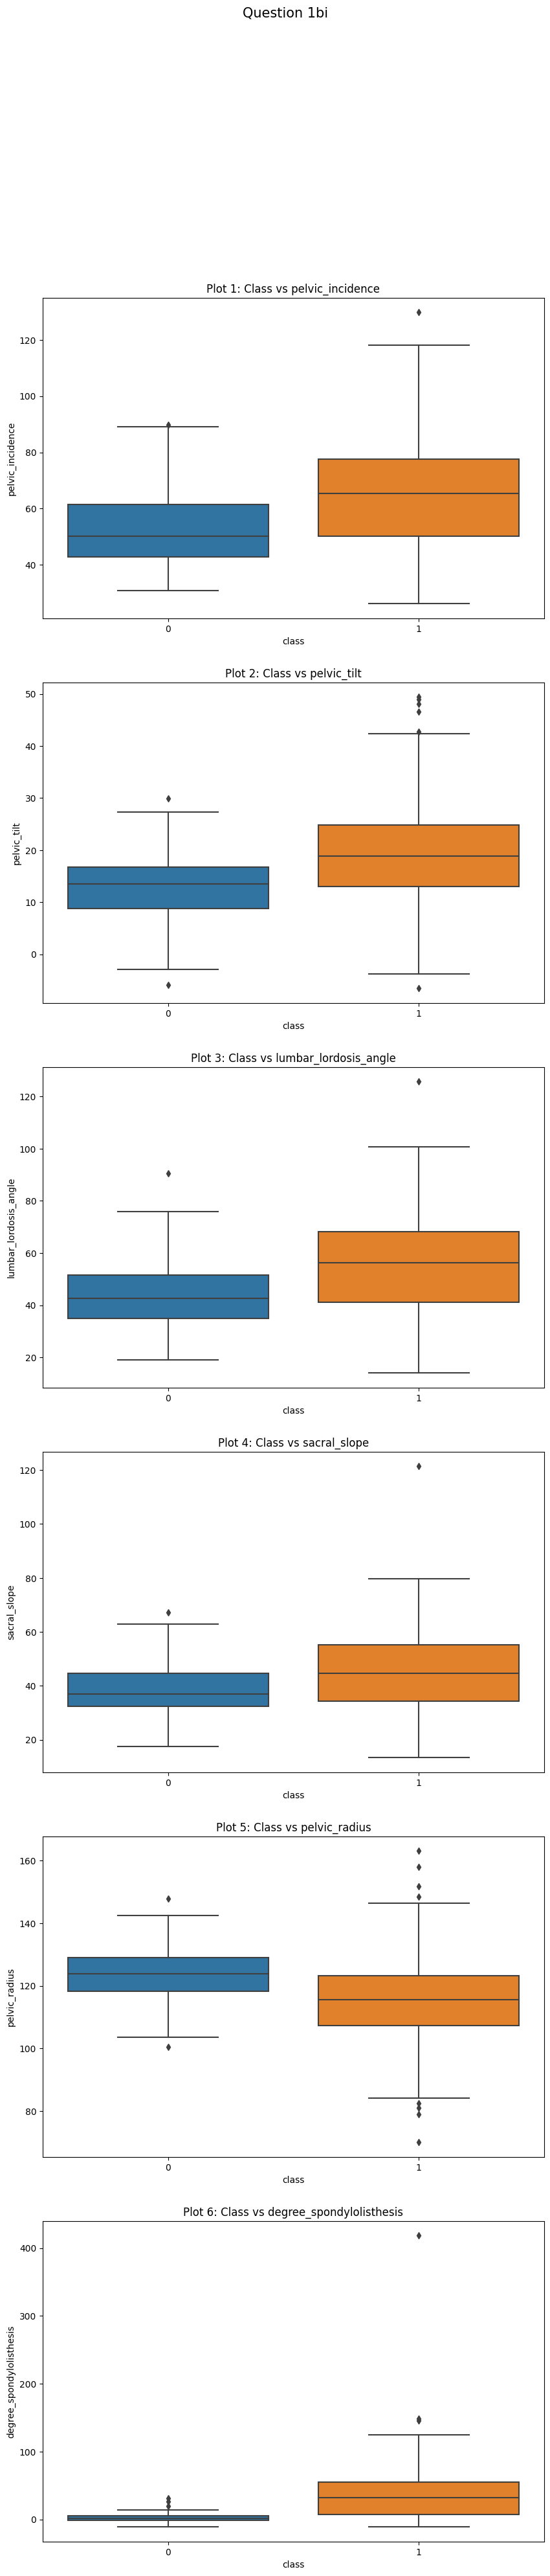

In [4]:
# pelvic_incidence, pelvic_tilt, lumbar_lordosis_angle, sacral_slope, pelvic_radius, degree_spondylolisthesis
fig, axs = plt.subplots(nrows=6,ncols=1,figsize=(10,45))

# Title for the entire plot
fig.suptitle("Question 1bi",fontsize=15)

for i in range(0, 6):
    sns.boxplot(df, x='class',y=features[i], ax= axs[i])
    axs[i].set_title("Plot {}: Class vs {}".format(i+1, features[i]))

#### iii. Split Data Set

In [5]:
# Filtering data as per classification value
data_nor, data_ab = df[df['class'] == 0], df[df['class'] == 1]
print("Total Length: {}, Normal Data: {}, Abnormal Data: {}".format(df.shape,len(data_nor), len(data_ab)))
# Randomly shuffling data
data_nor = data_nor.sample(frac=1)
data_ab = data_ab.sample(frac=1)
# Splitting the data
train_d = pd.concat([data_nor[0:70],data_ab[0:140]],axis=0)
test_d = df[~df.index.isin(train_d.index.values)]

Total Length: (310, 7), Normal Data: 100, Abnormal Data: 210


### (c) Classification

#### i. Euclidean Metric And Testing Data

Creating the X,Y Train and Test Datas, create global variable for minimum train error

In [6]:
# Get the required train and test data
train_X, train_y = train_d[features[:6]],train_d['class'].to_numpy()
test_X, test_y = test_d[features[:6]],test_d['class'].to_numpy()
min_train = float('inf')

Creating Model using KNN and finding the best value of 'k' based on Misclassification

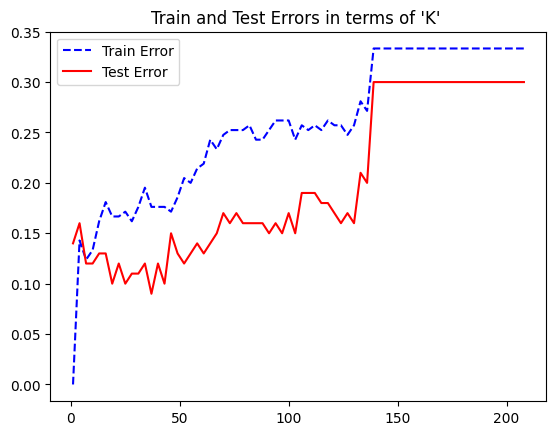

In [7]:
'''
KNN Classifier class:
p = 2 == Euclidean Metric
p = 1 == Manhattan distance
n_neighbors = neighbors
'''
# Store errors per neighbour
error_train, error_test = [], []

# Create the list of neighbours required
k_list = [i for i in range(1, 209, 3)]

for n in k_list:
    # Fit the model
    model = KNeighborsClassifier(n_neighbors=n, p = 2)
    model.fit(train_X, train_y)
    
    # Get the predictions
    pred_train = np.array(model.predict(train_X))
    pred_test = np.array(model.predict(test_X))

    # Calculating and Storing 
    error_train.append(1- accuracy_score(y_pred=pred_train, y_true=train_y))
    error_test.append(1- accuracy_score(y_pred=pred_test, y_true=test_y))
min_train = min(min_train, min(error_train))

plt.plot(k_list,error_train,color='blue', linestyle='dashed', label='Train Error')
plt.plot(k_list,error_test,color='red', label='Test Error')
plt.legend(loc='best')
plt.title("Train and Test Errors in terms of 'K' ")
plt.show()

#### ii. Test Data

In [8]:
k_star = k_list[pred_test.min()] # Most suitable
model = KNeighborsClassifier(n_neighbors=k_star, p = 2)
model.fit(train_X,train_y)
prediction = model.predict(test_X)
conf_matrix = confusion_matrix(y_pred=prediction, y_true=test_y)
print("Confusion Matrix: \n{}".format(conf_matrix))


TN, FP, FN, TP = conf_matrix.ravel()
# # Sensitivity, hit rate, recall, or true positive rate
true_positive_rate = TP/(TP+FN)
# # Specificity or true negative rate
true_negative_rate = TN/(TN+FP) 
# Precision
precision = TP/(TP + FP)
# Recall
recall = TP/(TP + FN)
# F-1 Score
F_score = (2*recall*precision)/(precision+recall)
print('True Positive Rate: {},\nTrue Negative Rate: {},\nPrecision: {},\nF-1 Score: {}'.format(true_positive_rate,true_negative_rate, precision, F_score))

Confusion Matrix: 
[[26  4]
 [12 58]]
True Positive Rate: 0.8285714285714286,
True Negative Rate: 0.8666666666666667,
Precision: 0.9354838709677419,
F-1 Score: 0.8787878787878788


#### iii. Learning Curve

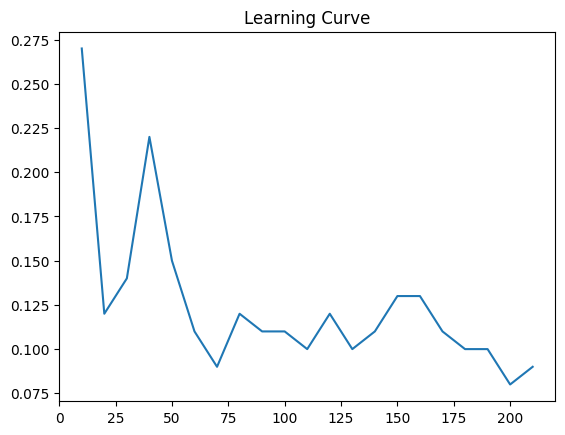

In [9]:
def createDatasets(N_values):
    data_nor, data_ab = train_d[train_d['class'] == 0],train_d[train_d['class'] == 1]
    data_nor, data_ab = data_nor.sample(frac=1), data_ab.sample(frac=1)
    datasets = []
    for each in N_values:
        nor_rows, ab_rows = each//3, (each- (each//3))
        datasets.append(pd.concat([data_nor[:nor_rows], data_ab[:ab_rows]], axis=0))
    return datasets

def getKNN(data, N_values):
    result = []
    for i,n in enumerate(N_values):
        test_errors = []
        for k in range(1, n, 5):
            model = KNeighborsClassifier(n_neighbors=k, p = 2)
            model.fit(data[i][features[:6]],data[i]['class'].to_numpy())
            pred_test = np.array(model.predict(test_X))
            test_errors.append(1-accuracy_score(pred_test, test_y))
        result.append(min(test_errors))
    return result
        
N_values = [i for i in range(10, 211,10)]
data = createDatasets(N_values)
best_errors = getKNN(data, N_values)

plt.plot(N_values,best_errors)
plt.title("Learning Curve")
plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

Function for getting the index of maximum 'K' with minimum test_error

In [10]:
# Reference: https://stackoverflow.com/questions/65742129/find-last-index-of-minimum-and-maximum-elements-in-list-python
def get_best_index(errors):
    return (len(errors) - errors[::-1].index(min(errors)) - 1)


##### A. Manhattan Distance with p = 1.

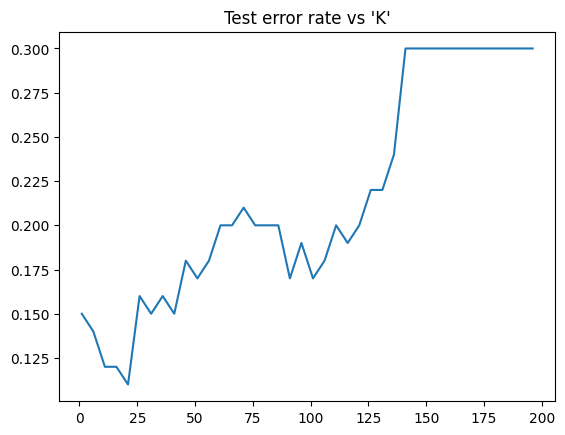

Best value of K: 21 and best test error rate: 0.10999999999999999


In [11]:
# Store errors per neighbour
error_test = []
error_train = []

# Create the list of neighbours required
k_list = [i for i in range(1, 200, 5)]

for n in k_list:
    # Fit the model
    model = KNeighborsClassifier(n_neighbors=n, p = 1)
    model.fit(train_X, train_y)
    # Get the predictions
    pred_test = np.array(model.predict(test_X))
    pred_train = np.array(model.predict(train_X))
    # Calculating and Storing 
    error_test.append(1-accuracy_score(test_y,pred_test))
    error_train.append(1-accuracy_score(train_y,pred_train)) 

min_train = min(min_train, min(error_train))
min_error = min(error_test)
best_k = []
for i in range(0,len(error_test)):
    if error_test[i] == min_error:
        best_k.append(k_list[i])

plt.plot(k_list,error_test)
plt.title("Test error rate vs 'K'")
plt.show()
print("Best value of K: {} and best test error rate: {}".format(best_k[-1], min_error))

##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

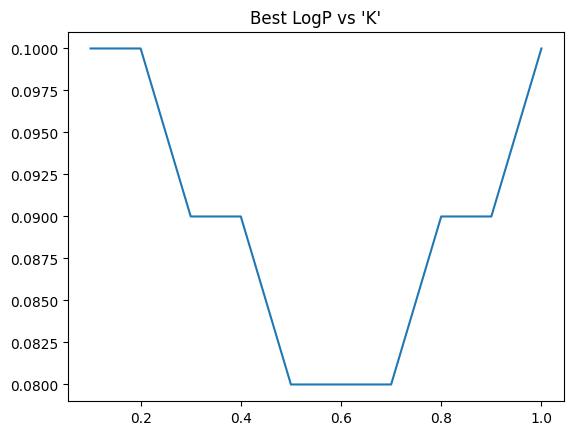

Best value of 'K': 21, Best value of Log base 10 of P: 0.7000000000000001 and best test error rate: 0.07999999999999996


In [12]:
# Create the list of neighbours required
logP = np.arange(0.1,1.1,0.1)

best_results = {} # Data structure {k: [error_test, minimum valued error, logP of that error]}

for k in best_k:
    error_test = []
    for p in logP:
        # Fit the model
        model = KNeighborsClassifier(n_neighbors=k, p = pow(10,p))
        model.fit(train_X, train_y)
        # Get the predictions
        pred_test = np.array(model.predict(test_X))
        # Calculating and Storing
        error_test.append(1-accuracy_score(test_y, pred_test))
        best_p = get_best_index(error_test)
    best_results[k] = [error_test, error_test[best_p], logP[best_p]]

# Finding the best 'k'
best_key = list(best_results.keys())[0]
smallest_error = best_results[best_key][1]
for result in best_results:
    if (smallest_error >= best_results[result][1]):
        smallest_error = best_results[result][1]
        best_key = result
        
plt.plot(logP, best_results[best_key][0])
plt.title("Best LogP vs 'K'")
plt.show()
print("Best value of 'K': {}, Best value of Log base 10 of P: {} and best test error rate: {}".format(best_key, best_results[best_key][2], best_results[best_key][1]))

##### C. Chebyshev Distance With p -> infinity.

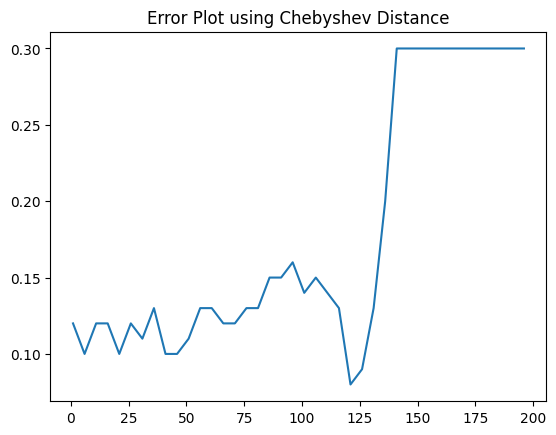

Best value of 'k': 121, and lowest test error rate: 0.07999999999999996


In [13]:
errors = []
errors_train = []
k_set = [i for i in range(1,200,5)]
for k in k_set:
    model = KNeighborsClassifier(n_neighbors=k, p = float('inf'))
    model.fit(train_X, train_y)
    # Get the predictions
    pred_test = np.array(model.predict(test_X))
    pred_train = np.array(model.predict(train_X))
    # Calculating and Storing
    errors.append(1-accuracy_score(test_y,pred_test))
    errors_train.append(1-accuracy_score(train_y,pred_train))

min_train = min(min_train, min(error_train))
index = get_best_index(errors)
plt.plot(k_set, errors)
plt.title("Error Plot using Chebyshev Distance")
plt.show()
print("Best value of 'k': {}, and lowest test error rate: {}".format(k_set[index], errors[index]))

#### ii. Mahalanobis Distance.

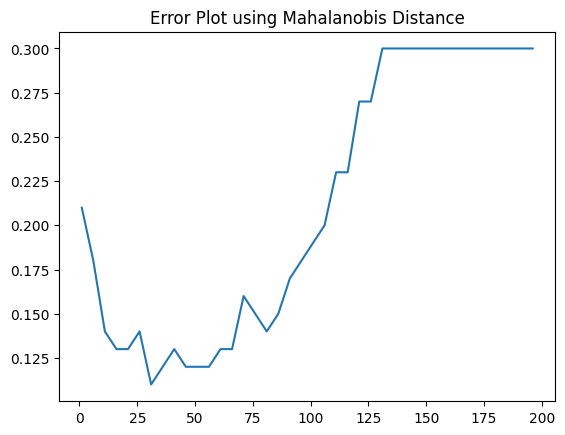

Best value of 'k': 31, and lowest test error rate: 0.10999999999999999


In [14]:
errors = []
errors_train = []
k_set = [i for i in range(1,200,5)]
for k in k_set:
    model = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': (np.linalg.inv(np.cov(train_X,rowvar=False)))})
    model.fit(train_X, train_y)
    # Get the predictions
    pred_test = np.array(model.predict(test_X))
    pred_train = np.array(model.predict(train_X))
    # Calculating and Storing
    errors.append(1-accuracy_score(test_y,pred_test))
    errors_train.append(1-accuracy_score(train_y,pred_train))

min_train = min(min_train, min(error_train))
index = get_best_index(errors)
plt.plot(k_set, errors)
plt.title("Error Plot using Mahalanobis Distance")
plt.show()
print("Best value of 'k': {}, and lowest test error rate: {}".format(k_set[index], errors[index]))

### (e) Weighted Decision

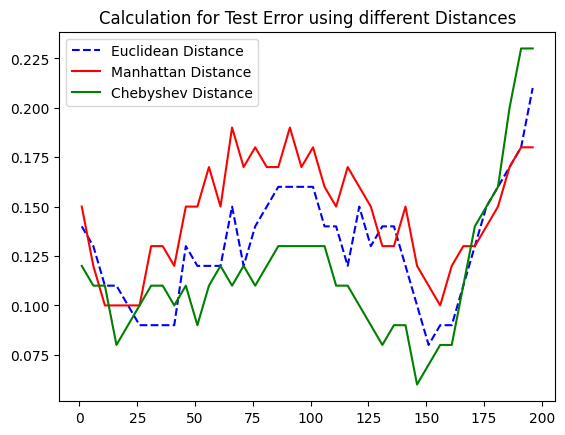

Minimum training error: 0.0
The best test errors for each:
Euclidean: 0.07999999999999996,
Manhattan: 0.09999999999999998,
Chebyshev: 0.06000000000000005


In [15]:
errors = [[],[],[]] # Euclidean, Manhattan, Chebyshev
k_set = [i for i in range(1,200,5)]
for k in k_set:
    model_e = KNeighborsClassifier(n_neighbors=k, weights='distance',p=2).fit(train_X,train_y)
    model_m = KNeighborsClassifier(n_neighbors=k, weights='distance',p=1).fit(train_X,train_y)
    model_c = KNeighborsClassifier(n_neighbors=k, weights='distance',p=float('inf')).fit(train_X,train_y)
    # Get the predictions
    pred_test_e = np.array(model_e.predict(test_X))
    pred_test_m = np.array(model_m.predict(test_X))
    pred_test_c = np.array(model_c.predict(test_X))
    # Calculating and Storing
    errors[0].append(1-accuracy_score(pred_test_e,test_y))
    errors[1].append(1-accuracy_score(pred_test_m,test_y))
    errors[2].append(1-accuracy_score(pred_test_c,test_y))


plt.title("Calculation for Test Error using different Distances")
plt.plot(k_set,errors[0],color='blue', linestyle='dashed', label='Euclidean Distance')
plt.plot(k_set,errors[1],color='red', label='Manhattan Distance')
plt.plot(k_set,errors[2],color='green', label='Chebyshev Distance')
plt.legend(loc='best')
plt.show()
print('Minimum training error: {}'.format(min_train))
print("The best test errors for each:\nEuclidean: {},\nManhattan: {},\nChebyshev: {}".format(min(errors[0]),min(errors[1]),min(errors[2])))

### (f) Training Error Rate

Minimum Training Error Rate is 0.0%